In [3]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem
from numpy.polynomial import polynomial

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI

In [6]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = True
initialize_photoZ = True

In [7]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [11]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel
0,12/8/2023,3_2,up,L2/3,Caudal,2
1,12/8/2023,4_1,NaN,L4,Rostral,2
2,12/8/2023,5_1,NaN,L4,Rostral,1
3,12/8/2023,5_2,NaN,L4,Rostral,2
4,12/8/2023,6_1,NaN,L4,NaN,1
5,12/8/2023,6_2,NaN,L4,NaN,2
6,12/13/2023,1_4,NaN,L2/3,Rostral,1
7,12/13/2023,2_1,NaN,L4,Rostral,1
8,12/13/2023,3_1,NaN,L4,Caudal,2
9,12/13/2023,3_2,NaN,L2/3,Caudal,2


In [16]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': subdir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(subdir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 2 15
3 2 16
3 2 17
4 1 1
4 1 2
4 1 3
4 1 4
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
5 1 2
5 1 3
5 1 4
5 1 5
5 1 6
5 1 7
5 1 8
5 1 9
5 1 10
5 1 11
5 1 12
5 1 13
5 1 14
5 1 15
5 1 16
5 1 17
5 2 2
5 2 3
5 2 4
5 2 5
5 2 6
5 2 7
5 2 8
5 2 9
5 2 10
5 2 11
5 2 12
5 2 13
5 2 14
5 2 15
5 2 16
5 2 17
6 1 4
6 1 5
6 1 6
6 1 7
6 1 8
6 1 9
6 1 10
6 1 11
6 1 12
6 1 13
6 1 14
6 1 15
6 1 16
6 1 17
6 1 18
6 1 19
6 2 1
6 2 2
6 2 3
6 2 4
6 2 5
6 2 6
6 2 7
6 2 8
6 2 9
6 2 10
6 2 11
6 2 12
6 2 13
6 2 14
6 2 15
6 2 16

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-13-23
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 4 11
1 4 12
1 4 13
1 4 14
1 4 15
1 4 16
1 4 17
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
3 1 2
3 1

{'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23': {3: {'roi_file': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/3_barrel_rois.dat',
   2: {'zda_files': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_01.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_02.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_03.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_04.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_05.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_06.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_07.zda',
     'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-ppr/12-08-23/03_02_08.zda',
     'C:/Users/jjudge3/D

In [19]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
if enable_photoZ_interact:
    raise NotImplementedError("What the")

NotImplementedError: What the

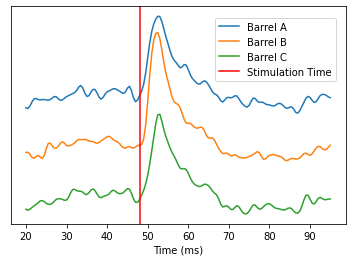

In [3]:
rcParams.update({'font.size': 10})

trace_sample = '11-27-23/selected_zda/Traces_02_01_03.dat'
trace_sample = pd.read_csv(data_dir + trace_sample,
                         sep='\t',
                         header=0,
                         names=['Index',  'Barrel C',  'Barrel B',  'Barrel A'])
plt.clf()
start_cut = 40
end_cut = 190
baseline = 3
v1 = trace_sample.loc[start_cut:end_cut, ["Barrel A"]] + baseline * 3
v2 = trace_sample.loc[start_cut:end_cut, ["Barrel B"]] + baseline * 2
v3 = trace_sample.loc[start_cut:end_cut, ["Barrel C"]] + baseline
t = [(i+start_cut) * 0.5 for i in range(len(v1))]
plt.plot(t, v1, label='Barrel A')
plt.plot(t, v2, label='Barrel B')
plt.plot(t, v3, label='Barrel C')
plt.axvline(x=48, label="Stimulation Time", color='red')
plt.legend(bbox_to_anchor=(0.79, .97), loc='upper center')
plt.yticks([])
plt.xlabel("Time (ms)")
plt.savefig(data_dir + "11-27-23/selected_zda/Traces_0ms.png")
plt.show() 